In [2]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import pandas as pd
from glucose_eval import AnalyteLabError

# 1. The Data

The data consists of blood analyte measuements over time. These analytes consist of glucose (GLU), sodium (NA+), and many more. We will focus only in glucose. The patients are identified with their Patient ID, i.e., '130', '131', '142', etc. Each patient has 2-3 different 'runs'. These runs are recorded in different dates. So for instance, df_130_0 refers to a run on date '0' for patient 130, df_130_1 refers to another run on date '1' for that same patient. 

In [3]:
df_130_0 = pd.read_csv('data/filtered_130_0.csv')
df_130_1 = pd.read_csv('data/filtered_130_1.csv')
df_130_2 = pd.read_csv('data/filtered_130_2.csv')

df_131_0 = pd.read_csv('data/filtered_131_0.csv')
df_131_1 = pd.read_csv('data/filtered_131_1.csv')
df_131_2 = pd.read_csv('data/filtered_131_2.csv')

df_149_0 = pd.read_csv('data/filtered_149_0.csv')
df_149_1 = pd.read_csv('data/filtered_149_1.csv')
df_149_2 = pd.read_csv('data/filtered_149_2.csv')

Note that the column 'Time' is in hours and minutes, so 618 is 6:18

In [100]:
df_130_0

,Time,CGM,HR,O2,BP,FS,HGB,BodyTemp,ExtTemp,VGG,...,HCT,A1C,Pic25,Pic26,Pic27,Pic28,Pic29,Pic30,Pic31,Pic32
0,618,122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,623,123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,628,123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,633,118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,638,122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1103,148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,1108,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,1113,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,1118,156.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note that most of these readings are NaN values, since the lab only records the measuement at certain point in time. So to visualize at what time where the values recorded, drop the NaNs.

In [4]:
glucose_vals_130_0 = df_130_0['GLU'].dropna()
time_at_glucose_130_0 = df_130_0['Time'][glucose_vals_130_0.index]
new_df_130_0 = pd.DataFrame({'Time': time_at_glucose_130_0, 'GLU': glucose_vals_130_0})

glucose_vals_130_1 = df_130_1['GLU'].dropna()
time_at_glucose_130_1 = df_130_1['Time'][glucose_vals_130_1.index]
new_df_130_1 = pd.DataFrame({'Time': time_at_glucose_130_1, 'GLU': glucose_vals_130_1})

glucose_vals_130_2 = df_130_2['GLU'].dropna()
time_at_glucose_130_2 = df_130_2['Time'][glucose_vals_130_2.index]
new_df_130_2 = pd.DataFrame({'Time': time_at_glucose_130_2, 'GLU': glucose_vals_130_2})

new_df_130_0

,Time,GLU
12,714,131.0
19,730,132.0
27,747,132.0
34,801,137.0
43,818,172.0
51,834,217.0
58,852,249.0
68,918,260.0
72,933,252.0
76,946,224.0


These runs have the purpose of monitoring glucose levels in the patients' blood. The patients come in fasting, so their glucose levels are 'stable'. At some point in time, the lab will give them a glucose tablet to ingest by mouth with the purpose of spiking up the readings. Finally, before the glucose levels rise up to a dangerous point, the patients get an insulin injection to bring the glucose back to normal.

You can observe this in the data itself, as the glucose values go from a stable number like 131 above, to 217 or 252, and back down to 181. 

Below is a visualization of the three runs for patient 130.

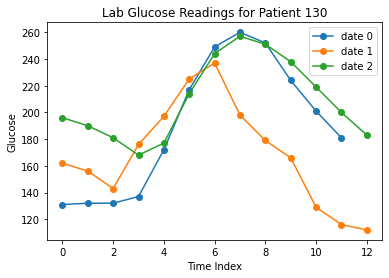

In [17]:
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(np.arange(0,12), new_df_130_0['GLU'], label='date 0', marker='o')
plt.plot(np.arange(0,13), new_df_130_1['GLU'], label='date 1', marker='o')
plt.plot(np.arange(0,13), new_df_130_2['GLU'], label='date 2', marker='o')
plt.title('Lab Glucose Readings for Patient 130')
plt.xlabel('Time Index')
plt.ylabel('Glucose')
plt.legend()
plt.show()

# 2) The Process

It would be nice if we could get a sense of what the 'true' value of glucose is, for any person, this would be very hard however, since each person is different and there are biological matters that we are ignoring. On the other hand, we can get a sense of what the true value of glucose is per patient. And we cna also get a sense of variation of these measurements.

We saw above that the first two glucose readings don't vary so much. For instance, in df_130_0 the first two glucose values are 131 and 132. Each run and patient is similar to this. So we can assume that the first two readings are the 'true' glucose value. However, they vary by a little, so we would have to take the mean:

$\mu_{130,0} = \frac{1}{2}(x_{(130,0)_0} + x_{(130,0)_1})$

where $x_{11}$ and $x_{12}$ are the first two 'true' values, i.e., 131 and 132 at date '0' for patient 130. And we we do this for all dates. So we get a list with $\mu_{130,0}, \mu_{130,1}, \mu_{130,2}$. So in general

As for the variance, the only sense of 'change' we can interpret here is how each run varied from another. So we get:

$V = \frac{1}{2n} \Sigma_i^n [(x_{i0}-\mu_i)^2 + (x_{i1}-\mu_i)^2]$

which if we keep following the example with patient 130, then:

$V = \frac{1}{2(3)} [(x_{(130,0)_0}-\mu_{130,0})^2 + (x_{(130,0)_1}-\mu_{130,0})^2] 
    + [(x_{(130,1)_0}-\mu_{130,1})^2 + (x_{(130,1)_1}-\mu_{130,1})^2] 
    + [(x_{(130,2)_0}-\mu_{130,2})^2 + (x_{(130,2)_1}-\mu_{130,2})^2] $.

Now with this variance we can now sample. Assume these values are normally distributed with varianve $V$, and with mean $x_{(130,0)_i}$ where $i$ is just the value of glucose. Yes, we are taking the actual value to be the mean since there is no other way of measuring this. Therefore, each glucose value ~$N(x_{(130,0)_i},V)$.
Note that this is only for patient 130, and for run 0. Eventhough we take into account all runs to calculate the variance, when we sample, the mean relies on a specific run.

Please refer to the file ''glucose_eval.py'' for reference.

In [221]:
err = AnalyteLabError([df_130_0,df_130_1,df_130_2], 'GLU')
mus, V = err.V_mus()
print('mu_{130,0}, \mu_{130,1}, \mu_{130,2} are: ', mus)
print('The variance is: ', V)

mu_{130,0}, \mu_{130,1}, \mu_{130,2} are:  [131.5 159.  193. ]
The variance is:  6.083333333333333


For visializing the sampling, we do a vanilla Monte Carlo model, where we sample from ~$N(x_{(130,0)_i},V)$ 10,000 times for each glucose measurement, for for each $i$:

KeyboardInterrupt: 

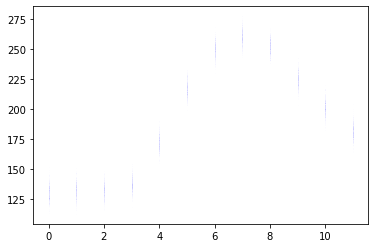

In [7]:
err.plot_draws(max_iters=10000)

# 4) Next Steps

Now, we would like to make this problem Bayesian, so a MCMC model will be implemented. We will sample from a prior distribution were we believe that is where the data comes from, and update as observations are presented to get the posterior, and then we will use a MCMC algorithm like Metropolis Hastings, to sample. Recall that in Bayesian statistics:

1. Define the prior distribution that incorporates your subjective beliefs about a parameter. The prior can be "uninformative" or "informative" (but there is no prior that has no information).
2. Gather data.
3. Update your prior distribution with the data using Bayes' theorem to obtain a posterior distribution. The posterior distribution is a probability distribution that represents your updated beliefs about the parameter after having seen the data.
4. Analyze the posterior distribution and summarize it (mean, median, sd, quantiles, ...).
The basis of all bayesian statistics is Bayes' theorem, which is

                                posterior∝prior×likelihood

I attached examples of how Monte Carlo and MCMC models work in the folder ''examples''. 



## The prior:
We will assume a prior to be distributed in the form ~$N(f(t_G),\hat{Q})$ and ~$N(h(t_I,I),\hat{Q})$.

So we will sample from two distributions:

1) ~$N(f(t_G),\hat{Q})$ will be the distribution to sample from, for the glucose values that are recorded at the beginning of the run and after the glucose values spike up from the ingestion of the tablet. 
    The function is $f(t_G) = x_{(i,j)_0} + G(logistic(t))k$.  Where $x_{(i,j)_0}$ is the first/initial glucose value recorded, $G$ is the amount of glucose they ingest at time $t_G$, which $G$ is a constant, and because of the shape of the graph, the increase in glucose I think would be best modeled with a logistic function of time, times some $k$, which $k$ is a value that scales it up and down as the graph grows.

Note that $G$ is always 50 mg. All patients are always given the same amount of glucose to ingest, however, this is not the case for the insulin. The insulin injection amount is tailored to each patient:

130_0 -18 u Insulin self administered in LLQ at 08:22
130_1 - 18 u Insulin self administered in Abdomen at 08:40
130_2 - 18 u Insulin self administered in Abdomen at 08:37

131_0 - 4.05 u Insulin self administered in Stomach and 07:52
131_1 - 5.5 u Insulin self administered in Stomach and 11:35
131_2 - 3.33 u Insulin self administered in Stomach and 13:27

142_0 - 2.45 u Insulin self administered in stomach at 0753
142_1 - 06.59 u Insulin self administered in abdomen at 0747
142_2 - 5.62 u Insulin self administered in stomach at 0740

143_0 - 5 u Insulin self administered in abdomen and 1220
143_1 - 5 u Insulin self administered via ABDOMEN AT 1239

149_0 - 4.32 u Insulin self-administered in left abdomen at 802
149_1 - 8 u Insulin self-administered in right abdomen at 758
149_2 - 6.25 u Insulin self-administered in left abdomen at 748

2) ~$N(h(t_I,I),\hat{Q})$ will be the distribution to sample from, for the glucose values that are recorded after the glucose values go down from when the inuslin injection is given.
    The function is $h(t_I,I)=We^{Itk}+C$. Where now, this function is dependent on $I$ because it changes since it is the amount of insulin each patient is given at time $t_I$. Because nos thw insulin is injected, and by the shape of the plot, I assume this function is an exponential decay. Here, $W$, $k$ and $C$ are just some values to scale the graph accordingly. 

Now, $\hat{Q}$ is the calculation of the variance just as before, except now with the modifications we have done.

Below there is a visual intuition of this explanation:


Here $\mu_0$ just refers to, for instance, $x_{(130,0)_0}$ for patient 130, run 0, the firist glucose value.

After incorporating the prior and posterior to use MCMC sampling, we can compare it to the vanilla Monte Carlo I did above and see where the new samples lie at.

In [222]:
# helper functions and constants

# Each tablet contains 50 mg of glucose
G = 50

# There are 12 parameters that change the overall function shape
PARAMS = ("$f_0$", "G", "$k_f$", "a", "b", "c", "$d_f$", "W", "I", "$k_h$", "C", "$d_h$")

# Global variance for priors
Q = 1


def normal(x, mu, sigma, as_log):
    den = (2*np.pi*(sigma**2))**0.5
    exp = - (x - mu)**2 / (2*(sigma**2))
    return exp - np.log(den) if as_log else np.exp(exp) / den

def logistic(x, a=1, b=1, c=1, d=0):
    return a / (1 + c * np.exp(-b * (x - d)))

def f(t, mu_0=0, G=1, k=1, *args, **kwargs):
    return mu_0 + G * logistic(t, *args, **kwargs) * k

def h(t, W=1, I=1, k=1, C=0, d=0):
    W = f(t) - C
    print('f: ', f(t))
    print('C: ', C)
    print('W: ', W)
    print('thing: ', W * np.exp(-I * (t - d) * k) + C)
    return np.abs(W) * np.exp(-I * (t - d) * k) + C

def get_default_params(kind):
    if kind.lower() in ("glucose", "glu", "f"):
        return [132, G, 2.5]  # [mu_0, G, k]
    if kind.lower() in ("insulin", "ins", "g", "h"):
        return [30, 18, 0.02, 160]  # [W, I, k, C]

def curve(t, params, cutoff=None):
    i = len(t) // 2 if cutoff is None else cutoff
    params_f, params_h = params[:7], params[7:]
    return np.concatenate((f(t[:i], *params_f), h(t[i:], *params_h)))

def curve_at(t, params, cutoff):
    params_f, params_h = params[:7], params[7:]
    return f(t, *params_f) if t < cutoff else h(t, *params_h)


f:  [0.99752738 0.99894919 0.99955379 0.99981059 0.99991961 0.99996588
 0.99998552 0.99999386]
C:  160
W:  [-159.00247262 -159.00105081 -159.00044621 -159.00018941 -159.00008039
 -159.00003412 -159.00001448 -159.00000614]
thing:  [-511.10107109 -332.91629987 -202.04342073 -105.91882891  -35.31604565
   16.5412878    54.63023642   82.60638831]


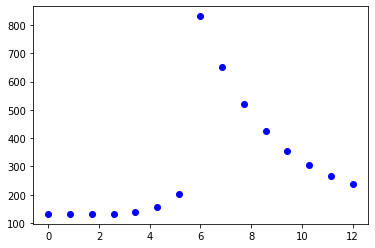

In [223]:
# Plot curve using default params
x = np.linspace(0, 12, 15)
cutoff = 0
mid_point = (len(x) // 2) + cutoff
plt.plot(x[:mid_point], f(x[:mid_point], *get_default_params("glucose"), b=2, d=5), 'bo')
plt.plot(x[mid_point:], h(x[mid_point:], *get_default_params("insulin"), d=10), 'bo')
plt.show()

f:  [0.99767244 0.9979376  0.9981726  0.99838086 0.99856543 0.99872898
 0.99887391 0.99900233 0.99911612 0.99921694 0.99930627 0.99938541
 0.99945553 0.99951765 0.99957269 0.99962145 0.99966465 0.99970292
 0.99973682 0.99976686 0.99979347 0.99981704 0.99983792 0.99985642
 0.99987281 0.99988733 0.99990019 0.99991158 0.99992167 0.99993061
 0.99993853 0.99994555 0.99995177 0.99995727 0.99996215 0.99996647
 0.9999703  0.99997369 0.99997669 0.99997935 0.99998171 0.9999838
 0.99998565 0.99998729 0.99998874 0.99999002 0.99999116 0.99999217
 0.99999306 0.99999386]
C:  1
W:  [-2.32755637e-03 -2.06240456e-03 -1.82740312e-03 -1.61913557e-03
 -1.43456997e-03 -1.27101626e-03 -1.12608810e-03 -9.97668924e-04
 -8.83881722e-04 -7.83062127e-04 -6.93734491e-04 -6.14590618e-04
 -5.44470860e-04 -4.82347331e-04 -4.27308998e-04 -3.78548446e-04
 -3.35350130e-04 -2.97079955e-04 -2.63176025e-04 -2.33140442e-04
 -2.06532032e-04 -1.82959895e-04 -1.62077682e-04 -1.43578528e-04
 -1.27190554e-04 -1.12672884e-04 -9.9

Text(0.5, 1.05, 'Sample curves with different parameter selection with positive W substitution')

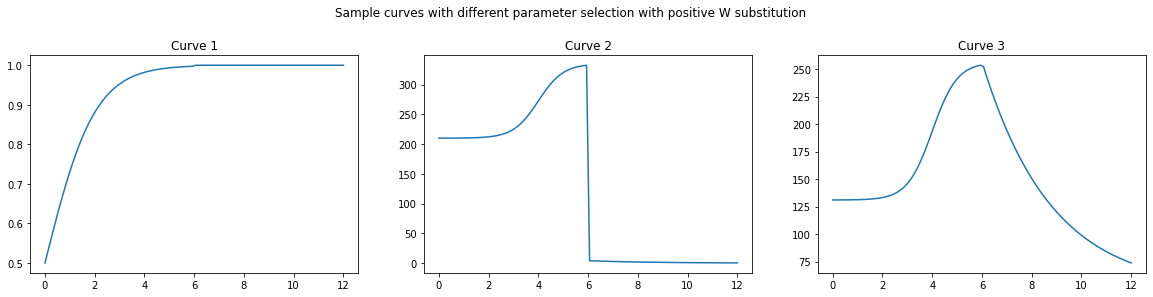

In [225]:
# different curves for different sets of params [f_0, G, k_f, a, b, d_f, W, I, k_h, C, d_h], with a,b,c,d as shape params
t = np.linspace(0,12,100)
y1  = curve(t, [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0])
y3 = curve(t, [131, G, 2.5, 1, 2, 1, 4, 18, 18, 0.02, 50, 10])
y2 = curve(t, [210, G, 2.5, 1, 2, 1, 4, 18, 18, 0.02, 0, 10])
_, ax = plt.subplots(1, 3, figsize=(20, 4))
ax[0].plot(t, y1)
ax[0].set_title('Curve 1')
ax[1].plot(t, y2)
ax[1].set_title('Curve 2')
ax[2].plot(t, y3)
ax[2].set_title('Curve 3')
plt.suptitle('Sample curves with different parameter selection with positive W substitution', y=1.05)


In [10]:
def draw_priors(doses, t_i):
    G, I = doses
    mu = np.abs(np.random.normal(150, 70))
    a = np.abs(np.random.normal((350 - mu) / G, 100 / G))
    b = np.random.exponential(125 / (G * a if G * a > 20 else 20 ))
    c = np.random.exponential(t_i / 2)
    k = np.abs(np.random.normal(0.1, 0.1))
    z = np.abs(np.random.normal(mu, 70))
    return [mu, a, b, c, k, z]

In [161]:
t = np.linspace(0, 12, 12)
t_i = 6
p130_doses = (50, 18)
p131_doses = (50, 4.05)
p149_doses = (50, 4.32)

y1 = f(t, p130_doses, draw_priors(p130_doses, 6))
y2 = f(t, p130_doses, draw_priors(p130_doses, 6))
y3 = f(t, p130_doses, draw_priors(p130_doses, 6))

y4 = f(t, p131_doses, draw_priors(t, p131_doses, 6))
y5 = f(t, p131_doses, draw_priors(t, p131_doses, 6))
y6 = f(t, p131_doses, draw_priors(t, p131_doses, 6))

y7 = f(t, p149_doses, draw_priors(t, p149_doses, 6))
y8 = f(t, p149_doses, draw_priors(t, p149_doses, 6))
y9 = f(t, p149_doses, draw_priors(t, p149_doses, 6))


_, ax = plt.subplots(3, 3, figsize=(20, 15))
ax[0][0].plot(t, y1)
ax[0][1].plot(t, y2)
ax[0][2].plot(t, y3)

ax[1][0].plot(t, y4)
ax[1][1].plot(t, y5)
ax[1][2].plot(t, y6)

ax[2][0].plot(t, y7)
ax[2][1].plot(t, y8)
ax[2][2].plot(t, y9)
plt.show()

ValueError: operands could not be broadcast together with shapes (6,) (12,) 

In [11]:
t_max = 12  # last point in time
mock_params = [131, G, 2.5, 1, 2, 1, 4, 18, 18, 0.02, 180, 10]

# Bounds on Priors
param_bounds = np.array([[100, 160],
                         [G, G],
                         [0, 5],
                         [0, 5],
                         [0, 5],
                         [0, 5],
                         [0, 5],
                         [10, 20],
                         [10, 20],
                         [0, 0.1],
                         [100, 200],
                         [10, 20]])

In [12]:
def simulate_data(t_max, params, sigma_y=1, num_samples=10000):
    np.random.seed(42)
    t = np.arange(t_max)
    mock_sigma = sigma_y + np.abs(np.random.normal(0.0, 1.0, size=t_max))
    mock_data = curve(t, params) + np.random.normal(0.0, mock_sigma)
    
    return mock_data, mock_sigma

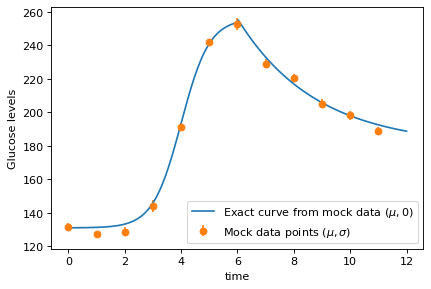

In [13]:
tt = np.linspace(0, t_max, 200)
mock_curve = curve(tt, mock_params)
mock_data, mock_sigma = simulate_data(t_max, mock_params, 2)

_ = plt.figure(figsize=(6,4), dpi=80)
plt.plot(tt, mock_curve, label="Exact curve from mock data ($\mu, 0$)")
plt.errorbar(np.arange(t_max), mock_data, mock_sigma, fmt='o', label="Mock data points ($\mu, \sigma$)")
plt.xlabel("time")
plt.ylabel("Glucose levels")
plt.legend()
plt.show()

In [14]:
def prior(t, params, insulin_time=6, as_log=True):
    p = normal(curve(t, params), 0, Q, as_log)
    return np.sum(p) if as_log else np.prod(p)

## Likelihood and Posterior

In [15]:
def likelihood(mu, sigma, data, as_log=True):
    # Evaluate the (log) normal of a proposed model mu, sigma against given data
    p = normal(data, mu, sigma, as_log)
    return np.sum(p) if as_log else np.prod(p)

In [16]:
def posterior(params, t, data, sigma, prior_params, insulin_time=6, as_log=True):
    l = likelihood(curve(t, params, insulin_time), sigma, data, as_log)
    p = prior(t, prior_params, insulin_time, as_log)
    return p + l if as_log else p * l

## MCMC

In [17]:
def propose(theta_prev, sigma_theta, theta_lo, theta_hi):
    """
    propose a new set of parameters 'theta' given the previous value
    'theta_prev' in the Markov chain. Choose new values by adding a 
    random Gaussian peturbation with standard deviation 'sigma_theta'.
    Make sure the new proposed value is bounded between 'theta_lo'
    and 'theta_hi'
    
    From https://github.com/pmocz/mcmc-python
    """
    # propose a set of parameters
    theta_prop = np.random.normal(theta_prev, sigma_theta)
    
    # reflect proposals outside of bounds
    too_hi = theta_prop > theta_hi
    too_lo = theta_prop < theta_lo

    theta_prop[too_hi] = 2*theta_hi[too_hi] - theta_prop[too_hi]
    theta_prop[too_lo] = 2*theta_lo[too_lo] - theta_prop[too_lo]
    
    return theta_prop

In [18]:
def metropolis_hastings(t, x, sigma, num_params, params_bounds=None, prior_params=None, insulin_time=6, N=9000, num_chains=4, burn_in=1000, thinning=100):
    assert (params_bounds is not None) ^ (prior_params is not None) == True
    
    if param_bounds is not None:
        lower_bounds, upper_bounds = params_bounds[:, 0], params_bounds[:, 1]
        assert len(lower_bounds) == num_params
        assert len(upper_bounds) == num_params
    
    param_chains = np.zeros((num_chains, N, num_params))   
    thin_chains = np.zeros((num_chains, (N - burn_in) // thinning, num_params))
    param_sigma = 0.02 * (upper_bounds - lower_bounds)
    
    for chain_i in range(num_chains):
        param_chain = param_chains[chain_i]
        
        if prior_params is None:
            # initial guess of params values. Size given by bounds arrays
            prior_params = np.random.uniform(lower_bounds, upper_bounds)
        
        current = prior_params

        for i in range(N):   
            proposed = propose(current, param_sigma, lower_bounds, upper_bounds)
    
            post_proposed = posterior(proposed, t, x, sigma, prior_params, insulin_time)
            post_current = posterior(current, t, x, sigma, prior_params, insulin_time)

            acceptance_prob = np.exp(np.min([0, post_proposed - post_current]))
    
            if (np.random.uniform() <= acceptance_prob):
                param_chain[i,:] = proposed
                current = proposed
            else:
                param_chain[i,:] = current
                
        thin_chains[chain_i] = param_chain[burn_in::thinning,:]
        
    return thin_chains

In [19]:
def plot_iterations(t_max, params_chain, insulin_time=6, step=100, n_cols=5, fig_size=10):
    N = len(params_chain)  # N has to be divisible by n_cols
    n_rows = N // step // n_cols
    fig_ratio = np.array([int(np.ceil(n_rows / n_cols)), 1])
    width, height = fig_size * (fig_ratio if n_rows < n_cols else fig_ratio[::-1])
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(width, height), sharex=True)
    t = np.linspace(0, t_max, 200)
    for i in range(0, N, step):
        c = curve(t, params_chain[i,:], np.max(np.where(t < insulin_time)))
        ax = axes[i // (step * n_cols)][i // step % n_cols]
        ax.plot(t, c, linewidth=0.5, color='k', label=f"i={i}")
        ax.legend()
        
    fig.tight_layout()

In [20]:
def plot_conv(chains, parameter_names):
    num_params = len(chains[0][0])
    assert num_params == len(parameter_names)

    fig, axes = plt.subplots(num_params, figsize=(12, 24), sharex=True)
    for i, parameter in enumerate(parameter_names):
        for chain_i, chain in enumerate(chains):
            axes[i].plot(chain[:, i], label=f'Chain {chain_i + 1}')
        axes[i].set_title(f'Convergence plot for {parameter}')
        axes[i].set_xlabel('Sample')
        axes[i].set_ylabel(parameter)
        axes[i].legend()
    plt.tight_layout()

In [28]:
def plot_posterior_densities(params, names=PARAMS, n_bins=20, expected=None):
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,10), dpi=80)
    
    for i, name in enumerate(names):
        ax = axes[i // 4][i % 4]
        ax.hist(params[:,i], n_bins, histtype='step', fill=True)
        if expected is not None:
            ax.axvline(expected[i], color='r', linewidth=1)
        ax.set_title(f'{name} posterior')

    fig.tight_layout()

In [21]:
# perform mcmc for mock data
chains = metropolis_hastings(np.arange(t_max), mock_data, mock_sigma, len(PARAMS), param_bounds)

In [22]:
chains.shape  # (number of chains, number of samples, number of parameters)

(4, 80, 12)

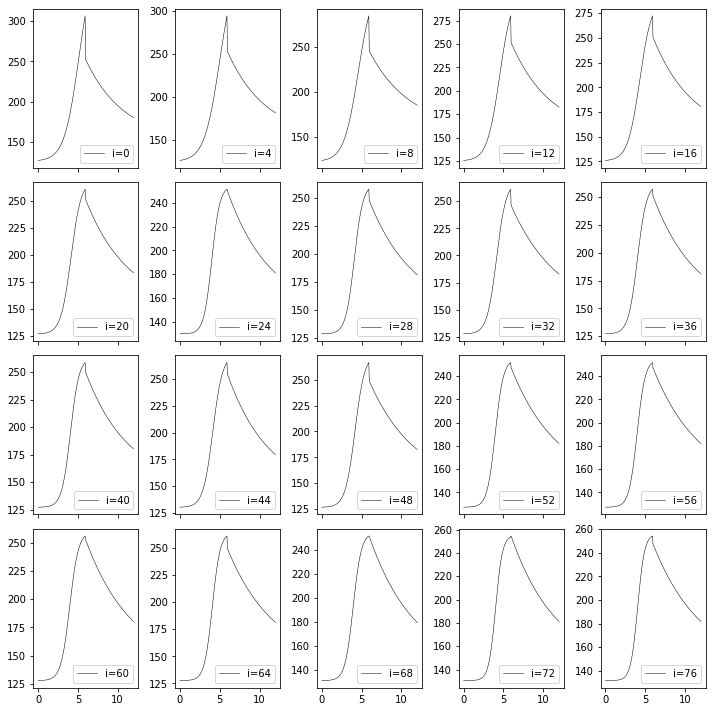

In [23]:
plot_iterations(t_max, chains[0], step=4, n_cols=5)

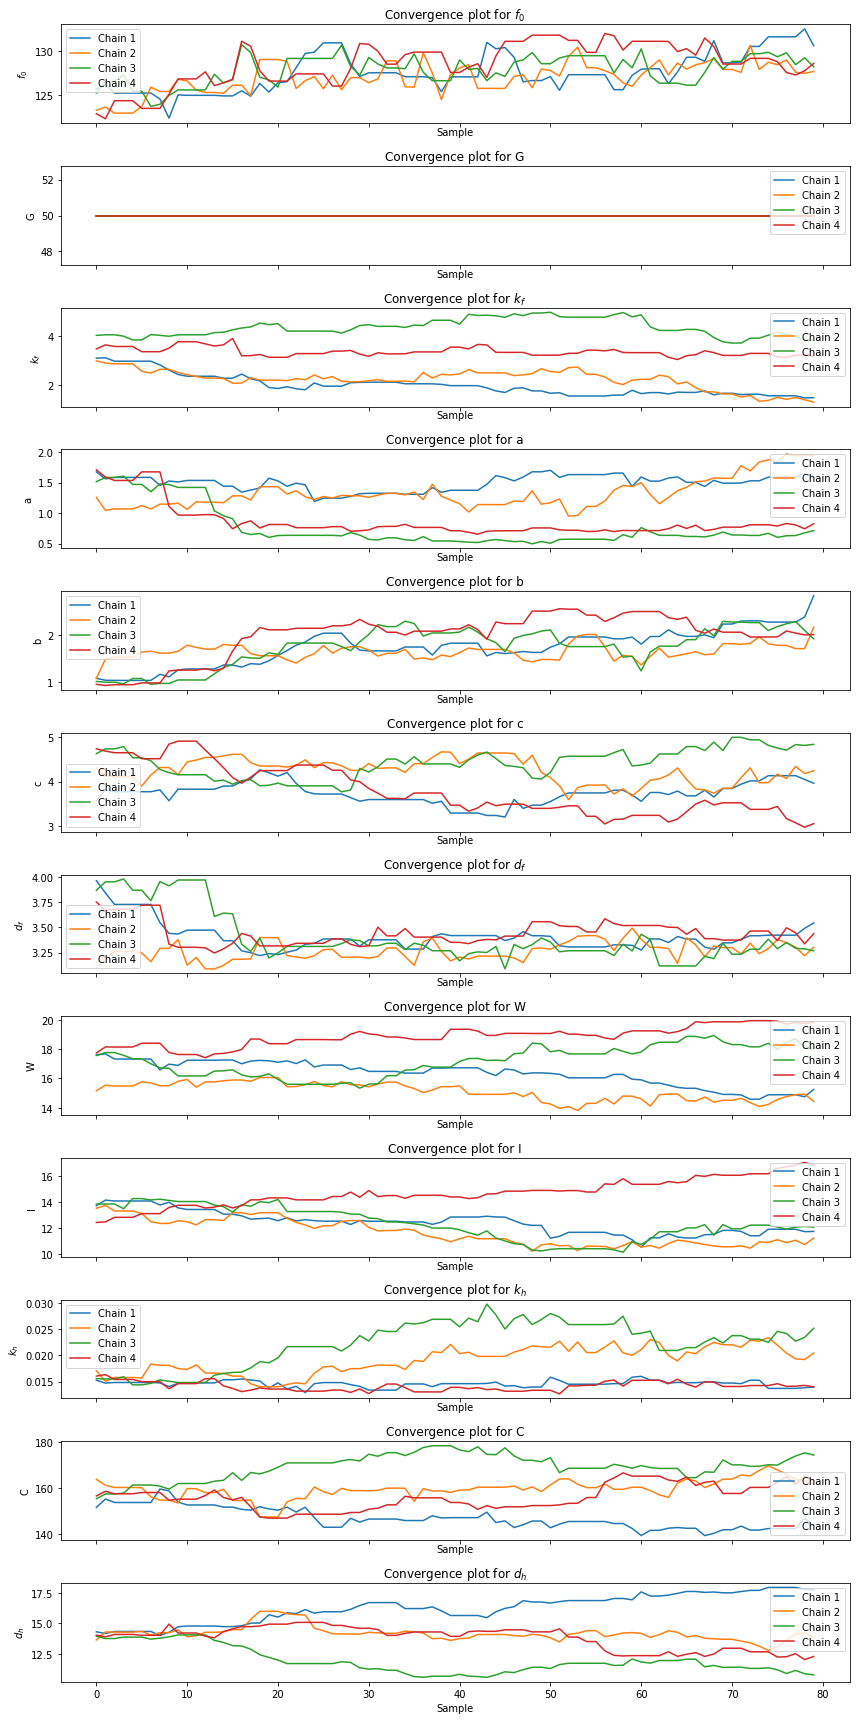

In [24]:
plot_conv(chains, PARAMS)

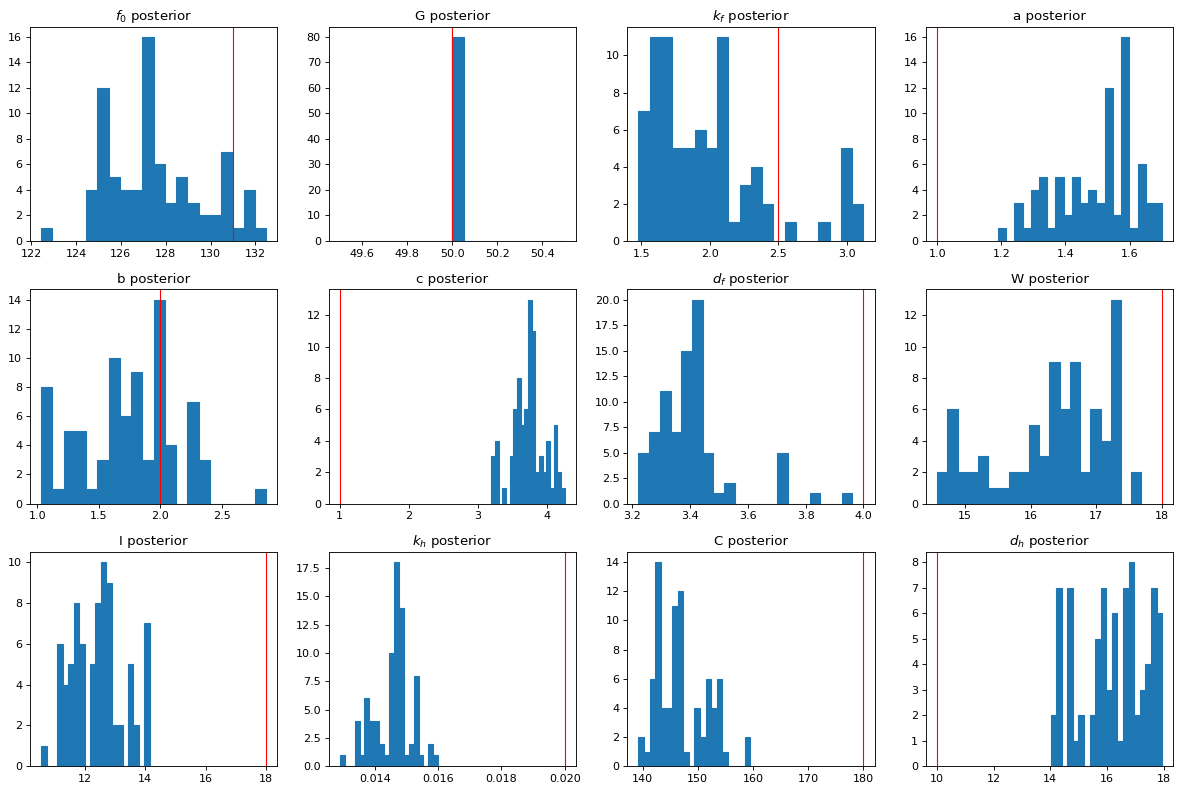

In [29]:
plot_posterior_densities(chains[0], expected=mock_params)

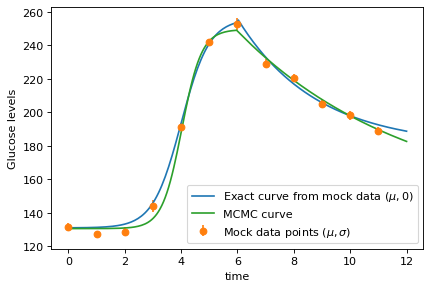

In [30]:
_ = plt.figure(figsize=(6,4), dpi=80)
plt.plot(tt, mock_curve, label="Exact curve from mock data ($\mu, 0$)")
plt.errorbar(np.arange(t_max), mock_data, mock_sigma, fmt='o', label="Mock data points ($\mu, \sigma$)")
plt.plot(tt, curve(tt, chains[0][-1,:]), label="MCMC curve")
plt.xlabel("time")
plt.ylabel("Glucose levels")
plt.legend()
plt.show()

## Real data test

In [31]:
default_sigma = 10.0
patient_id = "130"
patient_data = new_df_130_0
# patient_data = pd.concat([new_df_130_0, new_df_130_1, new_df_130_1])

# Group by specific HH:MM time
time_bucket, trunc = "Time", 1

# Group by hour (broader groups, less points)
# time_bucket, trunc = "Hour", 100

# Group by truncated HH:M (broader groups, some points)
# time_bucket, trunc = "HHM", 10

# patient_data[time_bucket] = patient_data.Time.apply(lambda x: x // trunc)

mean = patient_data[["GLU", time_bucket]].groupby(time_bucket).mean()
sigma = patient_data[["GLU", time_bucket]].groupby(time_bucket).std().fillna(default_sigma).replace(0, default_sigma)
data = mean.merge(sigma, "outer", time_bucket, suffixes=("_mean", "_std"))

In [32]:
data

,GLU_mean,GLU_std
Time,,
714,131.0,10.0
730,132.0,10.0
747,132.0,10.0
801,137.0,10.0
818,172.0,10.0
834,217.0,10.0
852,249.0,10.0
918,260.0,10.0
933,252.0,10.0


In [33]:
data_mu, data_sigma = data.GLU_mean, data.GLU_std

In [34]:
t_max = len(data)

param_bounds = np.array([[100, 150],
                         [G, G],
                         [0, 5],
                         [0, 5],
                         [0, 5],
                         [0, 5],
                         [0, 5],
                         [0, 5],
                         [0, 5],
                         [0, 0.1],
                         [0, 5],
                         [0, 150]])


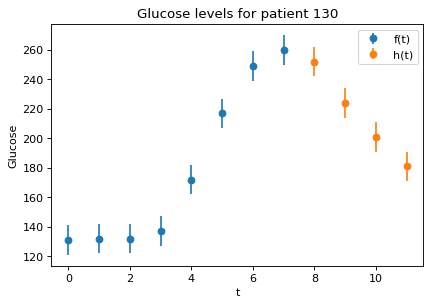

In [35]:
tt = np.linspace(0, t_max, 200)
insulin_time = t_max // 2 + 2

_ = plt.figure(figsize=(6,4), dpi=80)
plt.errorbar(np.arange(insulin_time), data_mu[:insulin_time], data_sigma[:insulin_time], fmt='o', label="f(t)")
plt.errorbar(np.arange(insulin_time, t_max), data_mu[insulin_time:], data_sigma[insulin_time:], fmt='o', label="h(t)")
plt.xlabel("t")
plt.ylabel("Glucose")
plt.title(f"Glucose levels for patient {patient_id}")
plt.legend()
plt.show()

In [36]:
chains = metropolis_hastings(np.arange(t_max), data_mu, data_sigma, len(PARAMS), param_bounds, insulin_time=insulin_time)

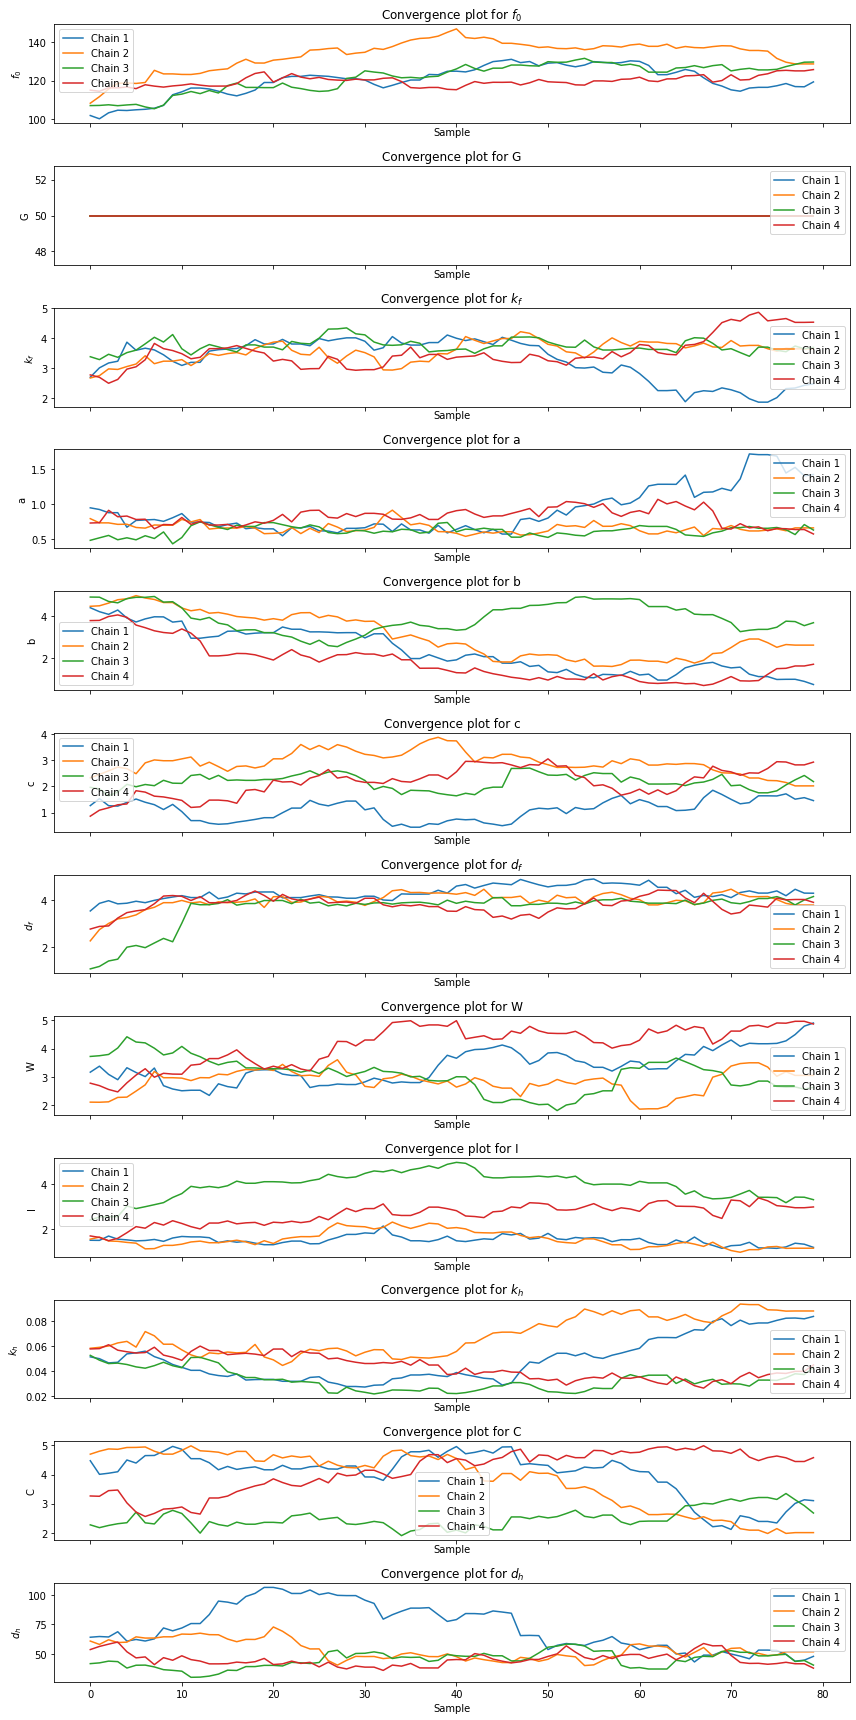

In [37]:
plot_conv(chains, PARAMS)

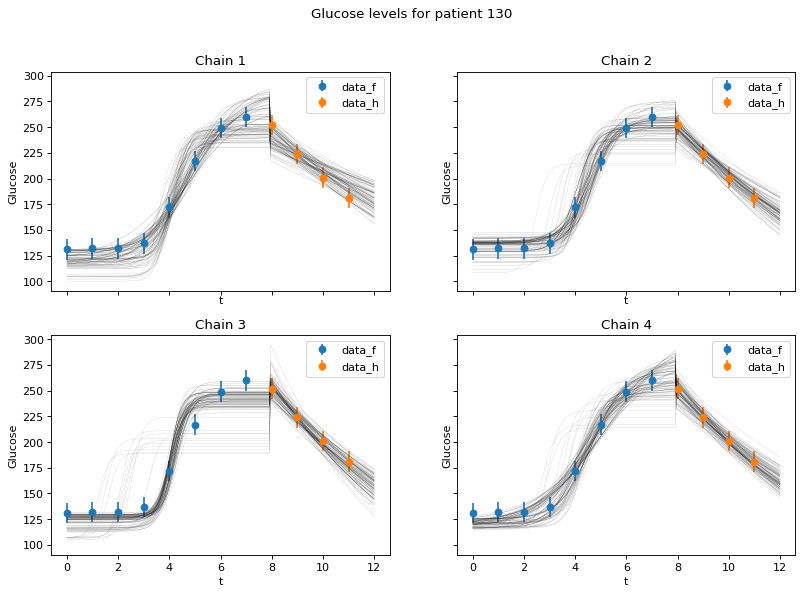

In [38]:
n_cols = 2
n_rows = len(chains) // n_cols
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 8), dpi=80, sharex=True, sharey=True)
fig.suptitle(f"Glucose levels for patient {patient_id}")
for i, chain in enumerate(chains):
    ax[i // n_rows, i % n_rows].errorbar(np.arange(t_max)[:insulin_time], data_mu[:insulin_time], data_sigma[:insulin_time], fmt='o', label="data_f")
    ax[i // n_rows, i % n_rows].errorbar(np.arange(t_max)[insulin_time:], data_mu[insulin_time:], data_sigma[insulin_time:], fmt='o', label="data_h")
    for j, params in enumerate(chain):
        c = (1 - j / len(chain)) * 0.5
        ax[i // n_rows, i % n_rows].plot(tt, curve(tt, params, np.max(np.where(tt < insulin_time))), linewidth=0.1, color=(c,c,c))
    ax[i // n_rows, i % n_rows].set_xlabel("t")
    ax[i // n_rows, i % n_rows].set_ylabel("Glucose")
    ax[i // n_rows, i % n_rows].set_title(f"Chain {i + 1}")
    ax[i // n_rows, i % n_rows].legend()

In [39]:
# chain 2 looks like the best fit
best_looking_chain = chains[1]

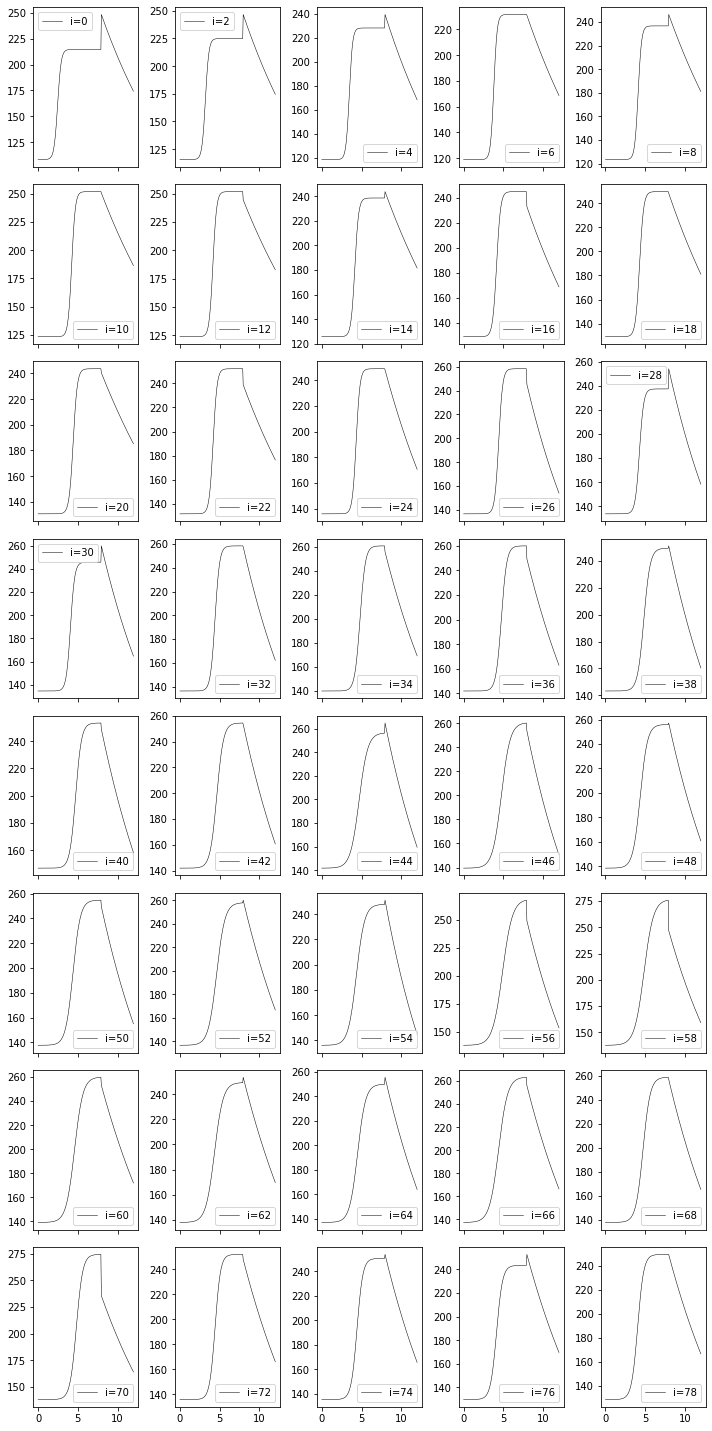

In [40]:
plot_iterations(t_max, best_looking_chain, insulin_time, step=2, n_cols=5)

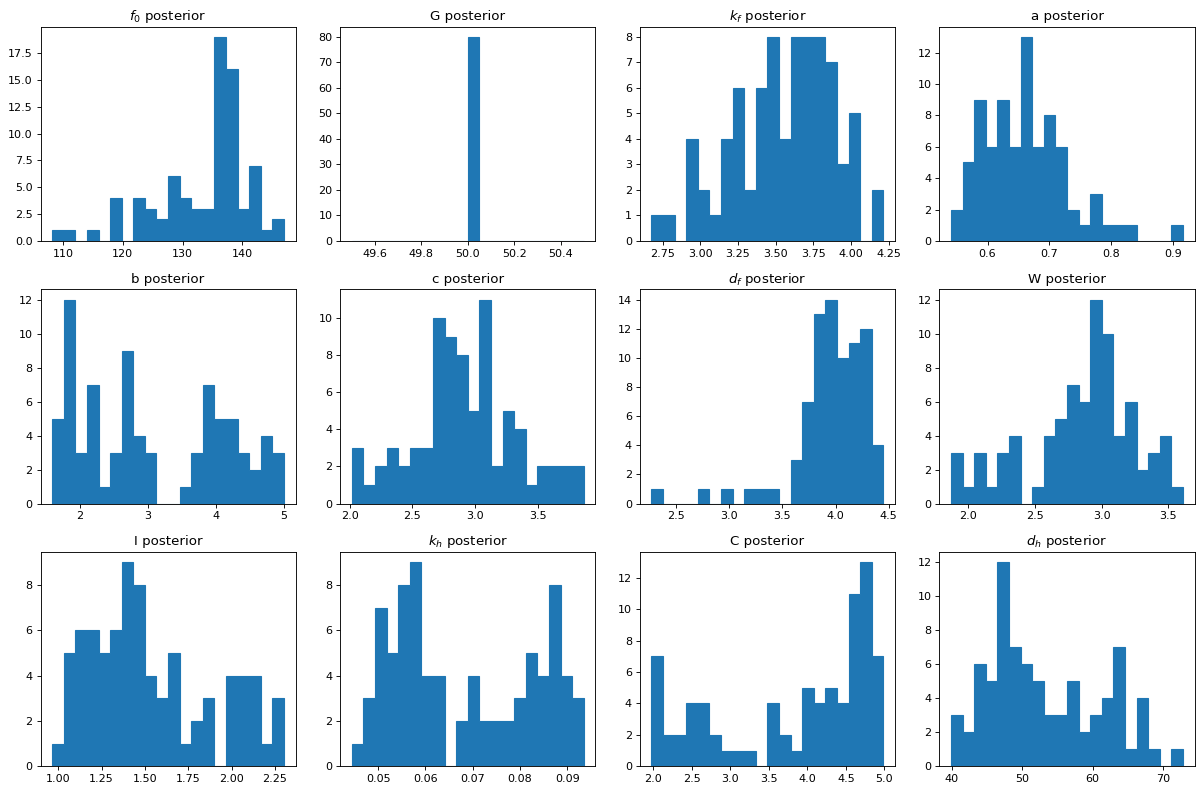

In [41]:
plot_posterior_densities(best_looking_chain)

## Attempt to estimate bounds automatically
Based on graphical estimations. See https://www.desmos.com/calculator/obmxzp8ygw

In [42]:
data["GLU_mean"]

Time
714     131.0
730     132.0
747     132.0
801     137.0
818     172.0
834     217.0
852     249.0
918     260.0
933     252.0
946     224.0
959     201.0
1014    181.0
Name: GLU_mean, dtype: float64

In [43]:
def estimate_params(data, num_params=12, G=G, I=18):
    # [f_0, G, k_f, a, b, c, d_f, W, I, k_h, C, d_h]
    params = np.zeros(num_params)
    
    # f(t) = f_0 + G * k * a / (1 + c * np.exp(-b * (x - d)))
    # f_0: glucose level at t = 0
    params[0] = data[0]
    
    # G: amount of glucose per tablet
    params[1] = G
    
    # k_f: scaling factor. Defaults to 1
    params[2] = 1
    
    # a: delta between glucose level at t = 0 and at t = t_insulin (which corresponds to local maximizer)
    params[3] = (data[np.argmax(data)] - params[0])
    params[3] /= G  # test: scale to a -- this ignores G
    
    # c: y-intercept for underlying exponential. It moves f from side to side at a log rate. Defaults to 1.
    params[5] = 1
    
    # d_f: time at inflection point for logistic curve. Moves f from side to side at a linear rate.
    d, s_max, s = 0, 0, 0
    for i in range(len(data) - 1):
        s = (data[i + 1] - data[i]) / data[i]
        if s > s_max:
            s_max, d = s, i
    params[6] = d
    
    # b: growth rate for logsitic curve
    params[4] = 1
    for t, p in enumerate(data):
        if 100 * (p - params[0]) / params[0] > 1:
            params[4] = np.exp((t - 0.75 * params[6]) / 0.8) + 0.8
            break
    
    # h(t) = W * np.exp(-I * (t - d) * k) + C
    # W: y-intercept for underlying exponential. It moves g from side to side at a log rate. Defaults to 1
    params[7] = 1
    
    # I: amount of insulin. Assumed constant for all measurements and patients
    params[8] = I
    
    # k_h: decay rate. Defaults to 0.1
    params[9] = 0.1
    params[9] /= I  #test: scale to k -- this ignores I
    
    # C: final stable glucose level
    h_delta = 100 * np.abs(data[-2] - data[-1]) / data[-1]
    params[10] = data[-1] if h_delta < 1 else params[0]
    
    # d_h: moves curve from side to side at a linear rate
    params[11] = (np.argmax(data) + params[6]) * 2

    return params
    

In [44]:
def estimate_bounds(data, delta_percent, num_params=12, G=G, I=18):
    params = estimate_params(data, num_params, G, I)
    bounds = np.tile(params, (2, 1)).T
    delta = (delta_percent/100) * bounds
    bounds[:, 0] -= delta[:, 0]
    if np.any(bounds[:, 0] < 0):
        bounds[:, 0] = np.zeros_like(bounds[:, 0])
    bounds[:, 1] += delta[:, 1]
    bounds[1, :] = G
    return bounds

In [45]:
t_max = len(data)

param_bounds = estimate_bounds(data_mu.to_numpy(), 50)

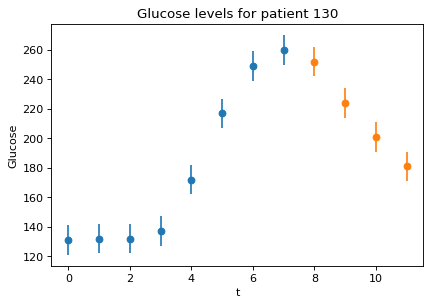

In [46]:
tt = np.linspace(0, t_max, 200)
insulin_time = t_max // 2 + 2

_ = plt.figure(figsize=(6,4), dpi=80)
plt.errorbar(np.arange(insulin_time), data_mu[:insulin_time], data_sigma[:insulin_time], fmt='o')
plt.errorbar(np.arange(insulin_time, t_max), data_mu[insulin_time:], data_sigma[insulin_time:], fmt='o')
plt.xlabel("t")
plt.ylabel("Glucose")
plt.title(f"Glucose levels for patient {patient_id}")
plt.show()

In [47]:
chains = metropolis_hastings(np.arange(t_max), data_mu, data_sigma, len(PARAMS), param_bounds, insulin_time=insulin_time)

In [90]:
chains.shape

(4, 80, 12)

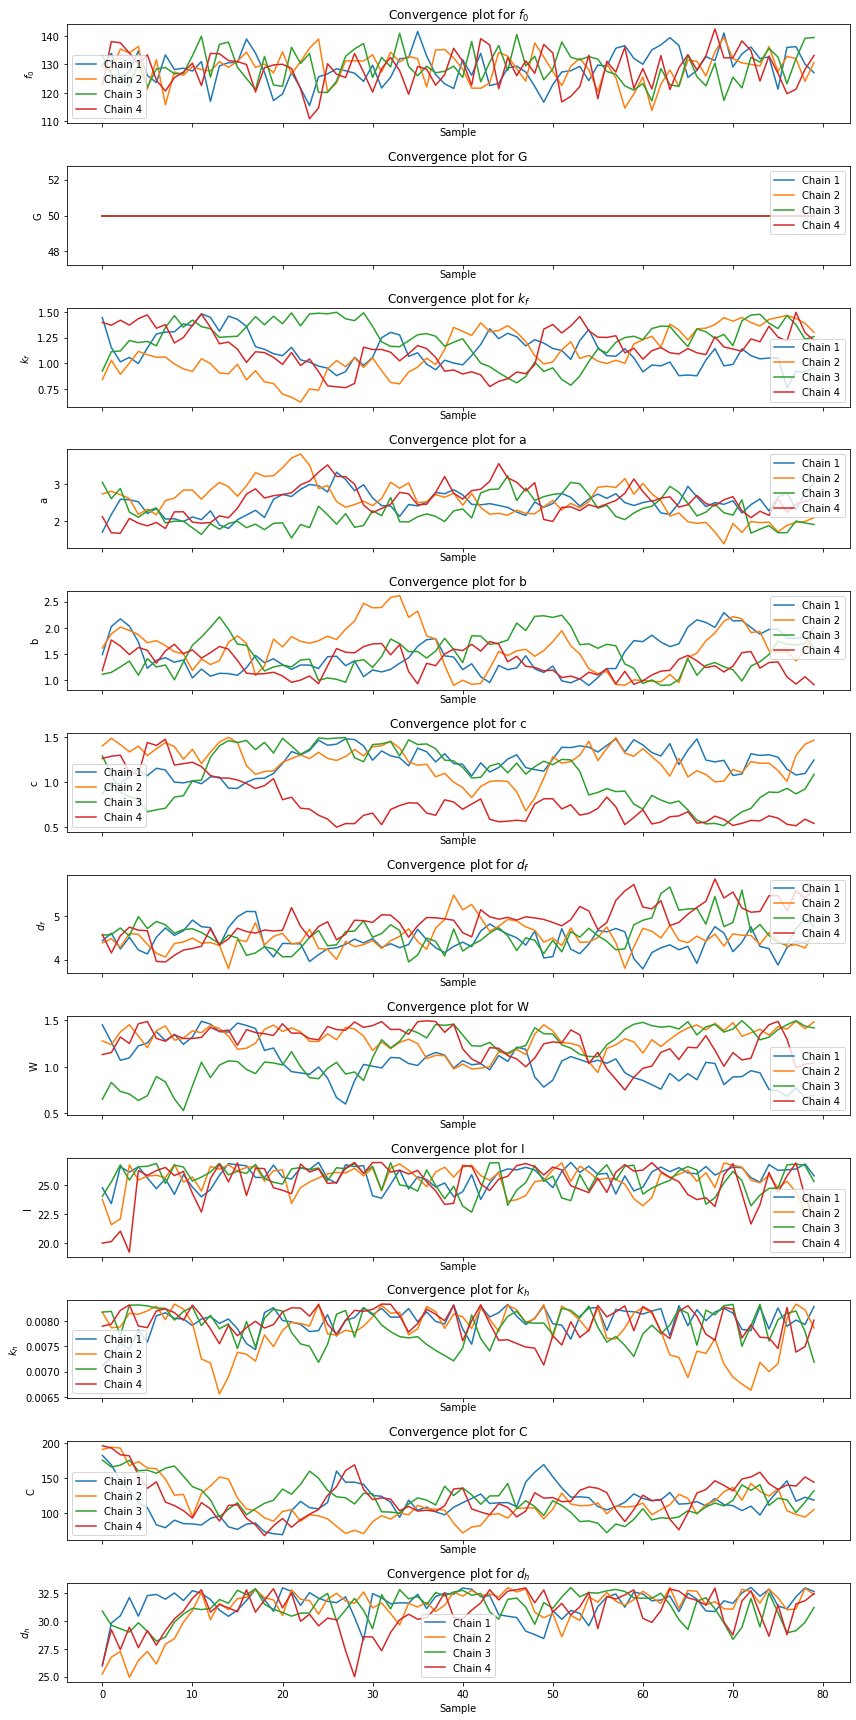

In [48]:
plot_conv(chains, PARAMS)

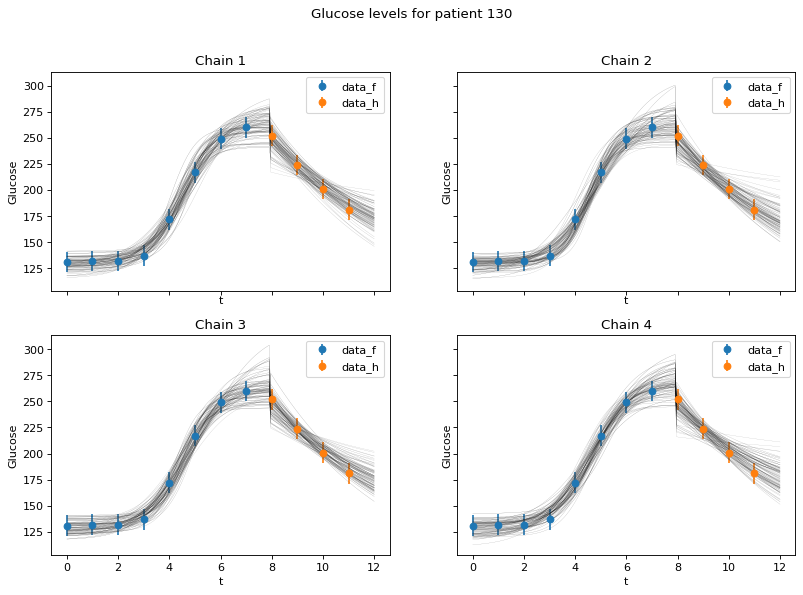

In [82]:
n_cols = 2
param_lists = []
n_rows = len(chains) // n_cols
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 8), dpi=80, sharex=True, sharey=True)
fig.suptitle(f"Glucose levels for patient {patient_id}")
for i, chain in enumerate(chains):
    ax[i // n_rows, i % n_rows].errorbar(np.arange(t_max)[:insulin_time], data_mu[:insulin_time], data_sigma[:insulin_time], fmt='o', label="data_f")
    ax[i // n_rows, i % n_rows].errorbar(np.arange(t_max)[insulin_time:], data_mu[insulin_time:], data_sigma[insulin_time:], fmt='o', label="data_h")
    for j, params in enumerate(chain):
        c = (1 - j / len(chain)) * 0.5
        ax[i // n_rows, i % n_rows].plot(tt, curve(tt, params, np.max(np.where(tt < insulin_time))), linewidth=0.1, color=(c,c,c))
        param_lists.append((curve(tt, params, np.max(np.where(tt < insulin_time)))))
    ax[i // n_rows, i % n_rows].set_xlabel("t")
    ax[i // n_rows, i % n_rows].set_ylabel("Glucose")
    ax[i // n_rows, i % n_rows].set_title(f"Chain {i + 1}")
    ax[i // n_rows, i % n_rows].legend()

In [96]:
chains.shape

(4, 80, 12)

In [50]:
best_looking_chain = chains[0]

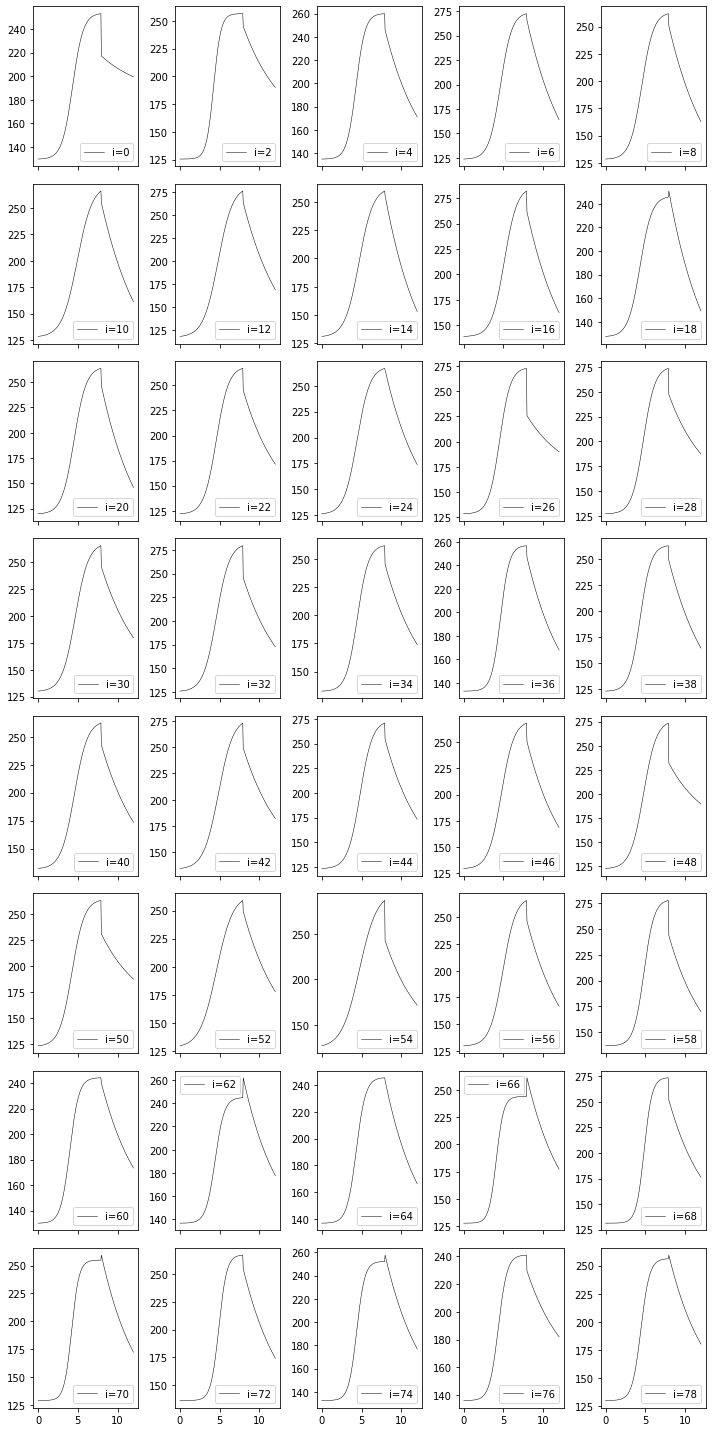

In [51]:
plot_iterations(t_max, best_looking_chain, insulin_time, step=2, n_cols=5)

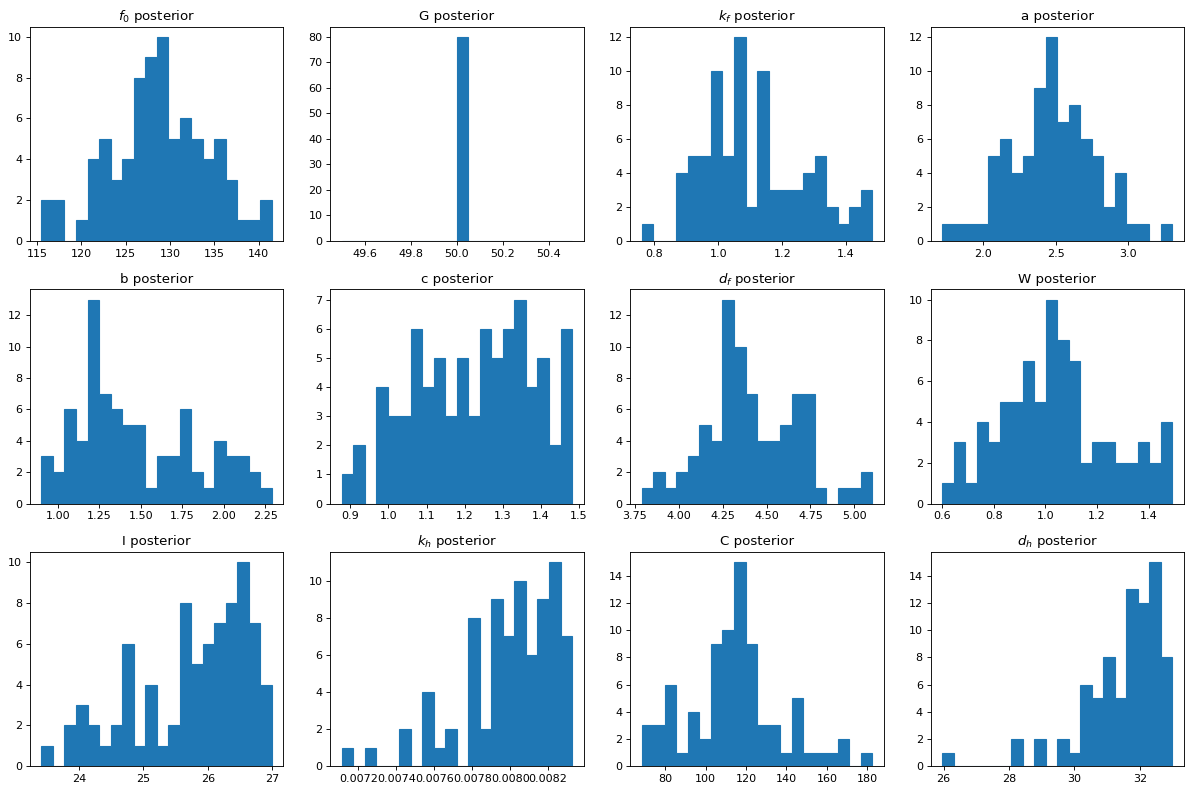

In [52]:
plot_posterior_densities(best_looking_chain)